# MIMO (spatial multiplexing) with convolutional coding

This example demonstrates how to use the Modulator_ND (MIMO) class for soft-output demodulation. The program simulates a simple convolutionally coded spatial-multiplexing (V-BLAST style) MIMO system with maximum-likelihood, alternatively zero-forcing, demodulation and soft Viterbi decoding, but no iteration between the demodulator and the decoder. Original C++ version of this example is available at http://itpp.sourceforge.net/4.3.1/mimoconv.html.

In [5]:
# Imports
import py_itpp as pyp
from matplotlib import pyplot as plt

In [6]:
#  Set up the convolutional encoder/decoder class:
#  In this example we will simulate a rate 1/3 code that is listed in J. G. Proakis,
#  "Digital communications". The encoder has constraint length 7.
conv_code = pyp.convcode.Convolutional_Code()

generators = pyp.vec.ivec(3)
generators[0] = 91  # Octal 0133
generators[1] = 101 # Octal 0145
generators[2] = 125 # Octal 0175
constraint_length = 7
conv_code.set_generator_polynomials(generators, constraint_length)

nrof_uncoded_bits = 10 # Information bits in packet

dummy = pyp.vec.bvec()
conv_code.encode_tail(pyp.random.randb(nrof_uncoded_bits), dummy)
nrof_coded_bits = dummy.length() # find out how long the coded blocks are
rate = float(nrof_uncoded_bits) / float(nrof_coded_bits)

constellation_index = 1 # 1=QPSK, 2=16-QAM, 3=64-QAM
nrof_transmit_antenna = 4
nrof_receive_antenna = 4
nrof_coherent_samples = 10 # coherence time (number of channel samples with same coefficients)
    
nrof_bits_per_channel_use = 2 * constellation_index * nrof_transmit_antenna
nrof_channel_use = int(nrof_coded_bits / nrof_bits_per_channel_use + 1)
nrof_transmit_bits = nrof_bits_per_channel_use * nrof_channel_use

# initialize MIMO channel with uniform QAM per complex dimension and Gray coding
mimo_modulator = pyp.modulator_nd.ND_UQAM(nrof_transmit_antenna, int(pyp.log_exp.pow(2, 2 * constellation_index)))

# initialize interleaver
sequence_interleaver_b = pyp.interleave.sequence_interleaver_bin(nrof_coded_bits)
sequence_interleaver_i = pyp.interleave.sequence_interleaver_int(nrof_coded_bits)

sequence_interleaver_b.randomize_interleaver_sequence()
sequence_interleaver_i.set_interleaver_sequence(sequence_interleaver_b.get_interleaver_sequence())

print("Initializing %d transmit antennas, %d receive antennas, %d-PAM per dimension, %d coherent samples"
      %(nrof_transmit_antenna, nrof_receive_antenna, pyp.log_exp.pow(2, constellation_index), nrof_coherent_samples))

# simulation control parameters
EbN0_db = pyp.vec.vec('-10:1:10') # SNR range
nrof_max_bits = 1000             # maximum number of bits to ever simulate per SNR point

if (nrof_coherent_samples == 1):   # Fast fading channel, BER is of primary interest
    ber_min = 0.001      # stop simulating a given method if BER<this value
    fer_min = -1         # do not stop on this condition
    nrof_bers = 1000     # move to next SNR point after counting 1000 bit errors
    nrof_fers = -1       # do not stop on this condition
else:                              # Slow fading channel, FER is of primary interest here
    ber_min = -1     # do not stop on this condition
    fer_min = 0.01       # stop simulating a given method if FER<this value
    nrof_bers = -1       # do not stop on this condition
    nrof_fers = 100      # move to next SNR point after counting 200 frame errors

if (pyp.log_exp.pow(2.0, nrof_bits_per_channel_use) > 256):   # ML decoder too complex
  print('WARNING: ML decoder too complex, try approximate approach')

if (nrof_transmit_antenna > nrof_receive_antenna):
  print('WARNING: Undetermined system, do not use ZF decoder ')

Initializing 4 transmit antennas, 4 receive antennas, 2-PAM per dimension, 10 coherent samples


In [ ]:
# Run simulations
pyp.random.RNG_reset(42)
received_symbols = [pyp.vec.cvec() for _ in range(nrof_channel_use)]  # received data

nrof_channel_samples = int(nrof_channel_use / nrof_coherent_samples) + 1
channel_coefficients = [pyp.mat.cmat() for _ in range(nrof_channel_samples)] # channel matrix (new matrix for each coherence interval)

uncoded_bit_error_counter = pyp.error_counters.BERC(indelay=0, inignorefirst=0, inignorelast=0)
coded_bit_error_counter = pyp.error_counters.BERC(indelay=0, inignorefirst=0, inignorelast=0)
frame_error_counter = pyp.error_counters.BLERC(nrof_uncoded_bits)
    
llr_in = pyp.vec.ivec(nrof_coded_bits)    
llr_priori = pyp.vec.ivec(nrof_bits_per_channel_use)  # no a priori input to demodulator
llr_posteriori = pyp.vec.ivec(nrof_bits_per_channel_use)
    
uncoded_bit_error_rate = []
coded_bit_error_rate = []
frame_error_rate = []
for snr_index in range(EbN0_db.length()):

  uncoded_bit_error_counter.clear()
  coded_bit_error_counter.clear()
  frame_error_counter.clear()

  energy_per_bit = 1.0 # transmitted energy per information bit
  noise_variance = pyp.log_exp.inv_dB(-EbN0_db[snr_index])
  energy_per_complex_symbol = rate * 2 * constellation_index * energy_per_bit # Energy per complex scalar symbol

  nrof_bits = 0
  while (nrof_bits < nrof_max_bits):

    nrof_bits = nrof_bits + nrof_uncoded_bits
    
    # generate and encode random data
    information_bits = pyp.random.randb(nrof_uncoded_bits)
    transmit_bits = pyp.vec.bvec()
    conv_code.encode_tail(information_bits, transmit_bits)
    
#    print(information_bits)
    
    # coded block length is not always a multiple of the number of transmit bits
    transmit_bits = pyp.vec.concat(transmit_bits, pyp.random.randb(nrof_transmit_bits - nrof_coded_bits))
#    transmit_bits = sequence_interleaver_b.interleave(transmit_bits)
        
#    print(transmit_bits)
        
    # generate channel and received symbols
    for k in range(nrof_channel_use):
      # A complex valued channel matrix is used here. An
      # alternative (with equivalent result) would be to use a
      # real-valued (structured) channel matrix of twice the dimension.
      channel_sample_index = int(k / nrof_coherent_samples)
      if (k % nrof_coherent_samples == 0):
        channel_coefficients[channel_sample_index] = pyp.elem_math.sqrt(energy_per_complex_symbol) * pyp.random.randn_c(nrof_receive_antenna, nrof_transmit_antenna);
        
#      print(channel_coefficients)
      # modulate transmit bits
      bits = transmit_bits.mid(k * nrof_bits_per_channel_use, nrof_bits_per_channel_use)
      sym = mimo_modulator.modulate_bits(bits)

      noise = pyp.elem_math.sqrt(noise_variance) * pyp.random.randn_c(nrof_receive_antenna)
      received_symbols[k] = channel_coefficients[channel_sample_index] * sym + noise
        
    # print('Received symbols generated!')
#    print(received_symbols)

    # demodulate
    llr_in.clear()
    llr_priori.clear()
    llr_posteriori.clear()
    for k in range(nrof_channel_use):
      channel_sample_index = int(k / nrof_coherent_samples)
      # zero forcing demodulation
      recv = received_symbols[k]
      chan = channel_coefficients[channel_sample_index]
        
      mimo_modulator.demodulate_soft_bits(received_symbols[k], channel_coefficients[channel_sample_index], noise_variance, llr_priori, llr_posteriori,
                                          pyp.modulator_nd.Soft_Demod_Method.FULL_ENUM_LOGMAP)
    
#      print(llr_posteriori)

      llr_in.set_subvector(k * nrof_bits_per_channel_use, llr_posteriori)
      #llr_in = sequence_interleaver_i.deinterleave(llr_in, 0)

    # decode and count errors
    # QLLR values must be converted to real numbers since the convolutional decoder wants this
    decoded_bits = pyp.vec.bvec()
    llr = mimo_modulator.get_llrcalc().to_double(llr_in.left(nrof_coded_bits))
    conv_code.decode_tail(llr, decoded_bits)
#    print(decoded_bits)

    uncoded_bit_error_counter.count(transmit_bits, (llr_in < 0))   # uncoded BER
    coded_bit_error_counter.count(information_bits, decoded_bits)  # coded BER
    frame_error_counter.count(information_bits, decoded_bits)      # coded FER
#    print(coded_bit_error_counter.get_errorrate())
    
#    print('---------------')
          
    # Check whether it is time to terminate the simulation.
    # Terminate when all demodulators that are still running have
    # counted at least nrof_bers or nrof_fers bit/frame errors.
    if (nrof_bers > 0 and coded_bit_error_counter.get_errors() > nrof_bers):
      break
    if (nrof_fers > 0 and frame_error_counter.get_errors() > nrof_fers):
      break

  uncoded_bit_error_rate.append(uncoded_bit_error_counter.get_errorrate())
  coded_bit_error_rate.append(coded_bit_error_counter.get_errorrate())
  frame_error_rate.append(frame_error_counter.get_errorrate())
  print('Eb/N0: %0.2f dB, simulated bits: %d, Uncoded BER: %0.2f, Coded BER: %0.2f, Coded FER: %0.2f'%(EbN0_db[snr_index],
                                                                                                       nrof_bits,
                                                                                                       uncoded_bit_error_counter.get_errorrate(),
                                                                                                       coded_bit_error_counter.get_errorrate(),
                                                                                                       frame_error_counter.get_errorrate()))

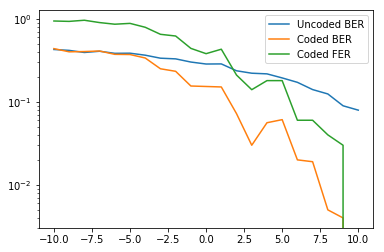

In [4]:
plt.figure()
plt.semilogy(EbN0_db.to_numpy_ndarray(), uncoded_bit_error_rate)
plt.semilogy(EbN0_db.to_numpy_ndarray(), coded_bit_error_rate)
plt.semilogy(EbN0_db.to_numpy_ndarray(), frame_error_rate)
plt.legend(['Uncoded BER', 'Coded BER', 'Coded FER'])
plt.show()